In [36]:
## Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from hurst import compute_Hc

import warnings
warnings.filterwarnings("ignore")

In [18]:
## Load files
def load_and_prepare_data(folder_path):
    """Loads and prepares data from CSV files in a given folder."""
    data_frames = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            instrument_name = file_name.split(".csv")[0]
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            asset_name = instrument_name.split("_")[0]
            data_frames[asset_name] = df
    return data_frames

folder_path = 'RawDataDoNotModify'
data_frames = load_and_prepare_data(folder_path)

In [28]:
## subcategory : dollar_index-0, bonds-1, currency-2, commodities-3, metal_commodities-4, agri_commodities-5, 
##                crypto-6, equity_index-7

assets_list = list(data_frames.keys())
assets_dict = {
                'USDCAD':['currency','2'],
                 'UKGILT.TRGBP':['bond','1'],
                 'AUDUSD':['currency','2'],
                 'BRENT.CMDUSD':['commodity','3'],
                 'DOLLAR.IDXUSD':['index','0'],
                 'XAUUSD':['commodity','3'],
                 'DIESEL.CMDUSD':['commodity','3'],
                 'COCOA.CMDUSD':['commodity','5'],
                 'BTCUSD':['crypto','6'],
                 'NZDUSD':['currency','2'],
                 'SUGAR.CMDUSD':['commodity','5'],
                 'USA500.IDXUSD':['index','7'],
                 'USSC2000.IDXUSD':['index','7'],
                 'SOYBEAN.CMDUSX':['commodity','5'],
                 'USDJPY':['currency','2'],
                 'EURUSD':['currency','2'],
                 'ETHUSD':['currency','2'],
                 'GBPUSD':['currency','2'],
                 'XAGUSD':['commodity','3'],
                 'COPPER.CMDUSD':['commodity','4'],
                 'USA30.IDXUSD':['index','7'],
                 'USDCHF':['currency','2'],
                 'LIGHT.CMDUSD':['commodity','3'],
                 'COTTON.CMDUSX':['commodity','5'],
                 'OJUICE.CMDUSX':['commodity','5'],
                 'USTBOND.TRUSD':['bond','1'],
                 'USATECH.IDXUSD':['index','7'],
                 'COFFEE.CMDUSX':['commodity','5'],
                 'GAS.CMDUSD':['commodity','3']
              }

assets_df = pd.DataFrame.from_dict(assets_dict, orient='index', columns=['Category', 'Sub_category']).reset_index()
assets_df.rename(columns={'index': 'Asset'}, inplace=True)
assets_df['Sub_category'] = assets_df['Sub_category'].astype('int')
assets_df

,Asset,Category,Sub_category
0,USDCAD,currency,2
1,UKGILT.TRGBP,bond,1
2,AUDUSD,currency,2
3,BRENT.CMDUSD,commodity,3
4,DOLLAR.IDXUSD,index,0
5,XAUUSD,commodity,3
6,DIESEL.CMDUSD,commodity,3
7,COCOA.CMDUSD,commodity,5
8,BTCUSD,crypto,6
9,NZDUSD,currency,2


In [29]:
assets_df['Sub_category'].value_counts()

2    8
3    6
5    6
7    4
1    2
0    1
6    1
4    1
Name: Sub_category, dtype: int64

In [104]:
assets_df[assets_df['Sub_category']==4]

,Asset,Category,Sub_category
19,COPPER.CMDUSD,commodity,4


### Idetifying current market condition 
Trending vs Mean Reverting

In [105]:
s_df = data_frames['GBPUSD']

In [106]:
s_df.tail(2)

,Local time,Open,High,Low,Close,Volume
40917,31.08.2024 22:00:00.000 GMT-0400,1.31231,1.31231,1.31231,1.31231,0.0
40918,31.08.2024 23:00:00.000 GMT-0400,1.31231,1.31231,1.31231,1.31231,0.0


In [72]:
window_size = 200

# Initialize a list to store Hurst exponent values
hurst_exp_list = []

# Loop through the data to calculate rolling Hurst exponent
for i in range(window_size, len(s_df)):
    window_data = s_df['Close'].iloc[i - window_size:i].values
    H, c, data = compute_Hc(window_data, kind='price', simplified=True)
    hurst_exp_list.append(H)

# Create a DataFrame for Hurst exponent values
hurst_df = pd.DataFrame(hurst_exp_list, index=s_df.index[window_size:], columns=['Hurst'])

# Merge with the original DataFrame
s_df = s_df.merge(hurst_df, left_index=True, right_index=True, how='left')

In [73]:
s_df.tail(2)

,Local time,Open,High,Low,Close,Volume,Hurst
40917,31.08.2024 22:00:00.000 GMT-0400,58796,58812,58248,58505,0.0160,0.621313
40918,31.08.2024 23:00:00.000 GMT-0400,58505,58626,58378,58483,0.0066,0.621664


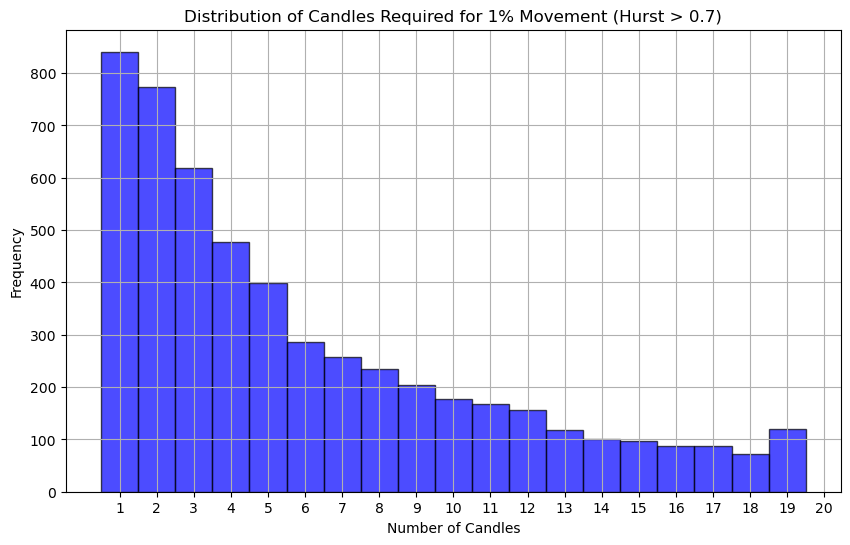

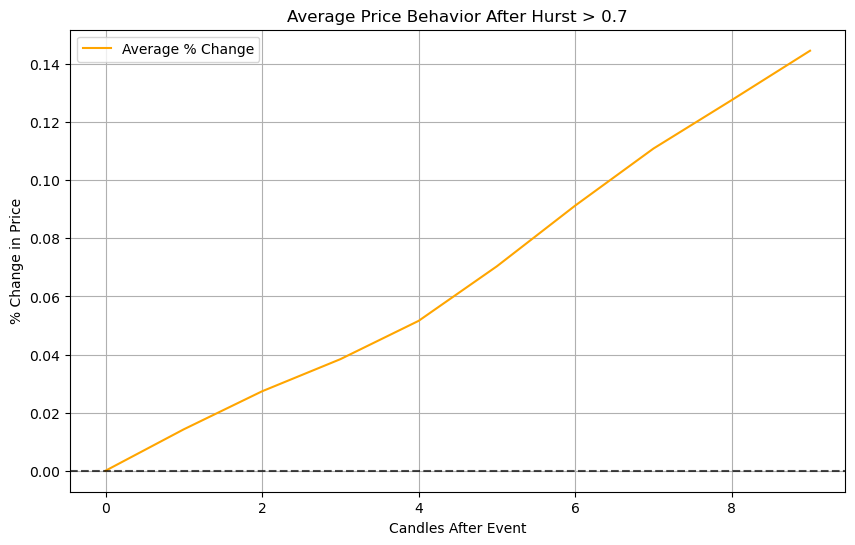

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming s_df is your DataFrame

# 1. Filter rows where Hurst > 0.7
high_hurst_df = s_df[s_df['Hurst'] > 0.7]

# 2. Calculate candles required for 1% price movement
candles_to_move = []
for index, row in high_hurst_df.iterrows():
    initial_price = row['Close']
    for i in range(index + 1, len(s_df)):
        current_price = s_df.loc[i, 'Close']
        price_change = (current_price - initial_price) / initial_price
        if abs(price_change) >= 0.01:  # 1% movement
            candles_to_move.append(i - index)
            break
    else:
        # If no 1% movement within the data range, add NaN
        candles_to_move.append(np.nan)

# Add the calculated values to the DataFrame
high_hurst_df['Candles_to_Move'] = candles_to_move

# Plot the Histogram with 20 bins, one bin per candle
plt.figure(figsize=(10, 6))
plt.hist(high_hurst_df['Candles_to_Move'].dropna(), bins=range(1, 21), color='blue', alpha=0.7, edgecolor='black', align='left')
plt.title('Distribution of Candles Required for 1% Movement (Hurst > 0.7)')
plt.xlabel('Number of Candles')
plt.ylabel('Frequency')
plt.xticks(range(1, 21))  # Ensure each bin is labeled from 1 to 20
plt.grid()
plt.show()


# 4. Analyze price behavior after Hurst > 0.7
price_behavior = []
for index, row in high_hurst_df.iterrows():
    initial_price = row['Close']
    future_prices = s_df['Close'][index:index+10].values  # Look at the next 10 candles
    price_behavior.append((future_prices - initial_price) / initial_price * 100)  # % change

# Create a DataFrame for price behavior analysis
price_behavior_df = pd.DataFrame(price_behavior).T
price_behavior_df.index.name = 'Candle'
price_behavior_df.columns = [f'Hurst_Event_{i+1}' for i in range(price_behavior_df.shape[1])]

# Plot the average price behavior
plt.figure(figsize=(10, 6))
plt.plot(price_behavior_df.index, price_behavior_df.mean(axis=1), label='Average % Change', color='orange')
plt.title('Average Price Behavior After Hurst > 0.7')
plt.xlabel('Candles After Event')
plt.ylabel('% Change in Price')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.legend()
plt.grid()
plt.show()


## Trend Ientification

In [82]:
from scipy.stats import linregress

# Define window size
window_size = 20  # Adjust based on analysis

# Initialize list to store slopes
slopes = [np.nan] * (window_size - 1)

# Convert time index to integer for regression
s_df['Local time'] = np.arange(len(s_df))

# Loop to calculate slope over rolling window
for i in range(window_size, len(s_df) + 1):
    y = s_df['Close'].iloc[i - window_size:i]
    x = s_df['Local time'].iloc[i - window_size:i]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    slopes.append(slope)

# Add slopes to DataFrame
s_df['Slope'] = slopes


In [83]:
s_df.tail()

,Local time,Open,High,Low,Close,Volume,Hurst,Slope
40914,40914,58987,59013,58901,58939,0.0029,0.590924,-11.243609
40915,40915,58938,59029,58869,58899,0.0054,0.606103,-7.872932
40916,40916,58896,58915,58793,58797,0.0056,0.608546,-7.578195
40917,40917,58796,58812,58248,58505,0.0160,0.621313,-11.818797
40918,40918,58505,58626,58378,58483,0.0066,0.621664,-16.493233


<Axes: ylabel='Density'>

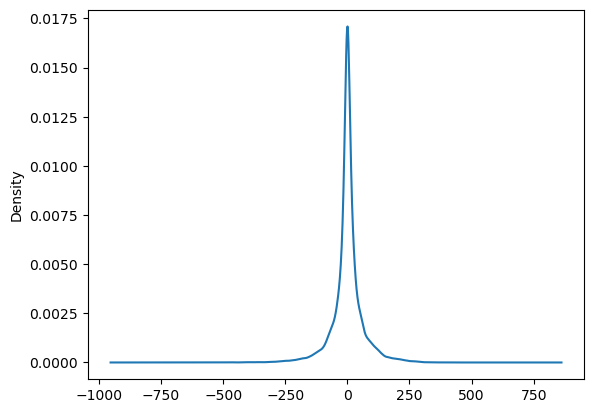

In [85]:
s_df['Slope'].plot(kind='density')

In [102]:
threshold = 200

price_up_count = s_df[(s_df['Slope'] > threshold) & (s_df['Close'] > s_df['Open'])].shape[0] / s_df[s_df['Slope']>threshold].shape[0]
price_down_count = s_df[(s_df['Slope'] < -threshold) & (s_df['Close'] < s_df['Open'])].shape[0]/ s_df[s_df['Slope']< -threshold].shape[0]

price_up_count, price_down_count

(0.558974358974359, 0.5034802784222738)

In [87]:
s_df.shape

(40919, 8)

In [103]:
s_df[s_df['Slope']>threshold].shape

(390, 8)

In [90]:
s_df[s_df['Slope']<0].shape

(19086, 8)

### Cross Sectional Regression

In [108]:
df = data_frames['UKGILT.TRGBP']
df.tail(2)

,Local time,Open,High,Low,Close,Volume
40917,31.08.2024 22:00:00.000 GMT-0400,98.468,98.468,98.468,98.468,0.0
40918,31.08.2024 23:00:00.000 GMT-0400,98.468,98.468,98.468,98.468,0.0


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# Function to compute log returns from 'Close' prices
def compute_log_returns(df):
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
    return df

# List of assets and their information
assets_info = [
    ('USDCAD', 'currency', 2),
    ('UKGILT.TRGBP', 'bond', 1),
    ('AUDUSD', 'currency', 2),
    ('BRENT.CMDUSD', 'commodity', 3),
    ('DOLLAR.IDXUSD', 'index', 0),
    ('XAUUSD', 'commodity', 3),
    ('DIESEL.CMDUSD', 'commodity', 3),
    ('COCOA.CMDUSD', 'commodity', 5),
    ('BTCUSD', 'crypto', 6),
    ('NZDUSD', 'currency', 2),
    ('SUGAR.CMDUSD', 'commodity', 5),
    ('USA500.IDXUSD', 'index', 7),
    ('USSC2000.IDXUSD', 'index', 7),
    ('SOYBEAN.CMDUSX', 'commodity', 5),
    ('USDJPY', 'currency', 2),
    ('EURUSD', 'currency', 2),
    ('ETHUSD', 'crypto', 6),
    ('GBPUSD', 'currency', 2),  # Target asset
    ('XAGUSD', 'commodity', 3),
    ('COPPER.CMDUSD', 'commodity', 4),
    ('USA30.IDXUSD', 'index', 7),
    ('USDCHF', 'currency', 2),
    ('LIGHT.CMDUSD', 'commodity', 3),
    ('COTTON.CMDUSX', 'commodity', 5),
    ('OJUICE.CMDUSX', 'commodity', 5),
    ('USTBOND.TRUSD', 'bond', 1),
    ('USATECH.IDXUSD', 'index', 7),
    ('COFFEE.CMDUSX', 'commodity', 5),
    ('GAS.CMDUSD', 'commodity', 3)
]

# Extract asset names
assets = [info[0] for info in assets_info]

# Initialize a dictionary to store DataFrames for each asset
data = {}

# Directory where your CSV files are stored
data_directory = 'RawDataDoNotModify'  # Replace with your actual path

# Load data and compute returns for each asset
for asset in assets:
    # Build file path
    asset_path = asset + "_Candlestick_1_Hour_BID_01.01.2020-31.08.2024"
    file_path = os.path.join(data_directory, f'{asset_path}.csv')
    # Load data
    df = pd.read_csv(file_path)
    # Parse 'Local time' as datetime
    df['Local time'] = pd.to_datetime(df['Local time'])
    # Ensure the data is sorted by 'Local time'
    df.sort_values('Local time', inplace=True)
    # Compute log returns from 'Close' prices
    df = compute_log_returns(df)
    # Store in the dictionary
    data[asset] = df

# Choose the market factor (e.g., DOLLAR.IDXUSD)
market_asset = 'DOLLAR.IDXUSD'
market_df = data[market_asset][['Local time', 'Return']].rename(columns={'Return': 'Market_Return'})

# Initialize the returns DataFrame with 'Local time'
returns_df = market_df[['Local time']].copy()

# Add market return
returns_df['Market_Return'] = market_df['Market_Return']

# Add returns of other assets (excluding GBPUSD for now)
for asset in assets:
    if asset != 'GBPUSD':
        asset_df = data[asset][['Local time', 'Return']].copy()
        asset_df.rename(columns={'Return': asset}, inplace=True)
        # Merge on 'Local time'
        returns_df = pd.merge(returns_df, asset_df, on='Local time', how='left')

# Add GBPUSD returns separately
gbpusd_df = data['GBPUSD'][['Local time', 'Return']].rename(columns={'Return': 'GBPUSD_Return'})
returns_df = pd.merge(returns_df, gbpusd_df, on='Local time', how='left')

# Drop rows with missing values
returns_df.dropna(inplace=True)

# First-Stage Time Series Regressions: Estimate betas for each asset (excluding GBPUSD)
betas = {}
for asset in assets:
    if asset != 'GBPUSD':
        y = returns_df[asset]
        X = returns_df[['Market_Return']]
        X = sm.add_constant(X)  # Adds intercept term
        model = sm.OLS(y, X).fit()
        betas[asset] = model.params['Market_Return']

# Estimate beta for GBPUSD
y = returns_df['GBPUSD_Return']
X = returns_df[['Market_Return']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
beta_gbpusd = model.params['Market_Return']

# Second-Stage Cross-Sectional Regressions: Estimate risk premia at each time point
risk_premia = []
expected_returns = []

# Convert betas dictionary to Series for easier indexing
betas_series = pd.Series(betas)

# Get list of timestamps
time_list = returns_df['Local time'].tolist()

# Loop over each timestamp to perform cross-sectional regression
for idx, time in enumerate(time_list):
    # Cross-sectional returns at time 't' (excluding GBPUSD)
    cs_returns = returns_df.iloc[idx][[asset for asset in assets if asset != 'GBPUSD']]
    # Get corresponding betas
    asset_betas = betas_series.loc[cs_returns.index]
    # Prepare regression variables
    y_cs = cs_returns.values
    X_cs = asset_betas.values.reshape(-1, 1)
    X_cs = sm.add_constant(X_cs)
    # Run cross-sectional regression
    cs_model = sm.OLS(y_cs, X_cs).fit()
    lambda_t = cs_model.params[1]  # Estimated risk premium at time 't'
    risk_premia.append({'Local time': time, 'Risk_Premium': lambda_t})
    # Forecast GBPUSD return using its beta and the estimated risk premium
    expected_return = beta_gbpusd * lambda_t
    expected_returns.append({'Local time': time, 'Expected_Return': expected_return})

# Convert lists to DataFrames and set 'Local time' as the column
risk_premia_df = pd.DataFrame(risk_premia)
expected_returns_df = pd.DataFrame(expected_returns)

# Merge expected returns with actual GBPUSD returns
results_df = pd.merge(returns_df[['Local time', 'GBPUSD_Return']], expected_returns_df, on='Local time', how='inner')

# Evaluate the Model

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(results_df['GBPUSD_Return'], results_df['Expected_Return'])
print(f"Mean Squared Error: {mse}")

# Calculate Correlation Coefficient between actual and expected returns
correlation = results_df[['GBPUSD_Return', 'Expected_Return']].corr().iloc[0, 1]
print(f"Correlation Coefficient: {correlation}")

# Plot the actual vs. expected GBPUSD returns
plt.figure(figsize=(14, 7))
plt.plot(results_df['Local time'], results_df['GBPUSD_Return'], label='Actual GBPUSD Return')
plt.plot(results_df['Local time'], results_df['Expected_Return'], label='Expected GBPUSD Return', alpha=0.7)
plt.legend()
plt.title('Actual vs. Expected GBPUSD Returns')
plt.xlabel('Local time')
plt.ylabel('Return')
plt.show()
